In [1]:
from scalecast.Forecaster import Forecaster
from scalecast.util import infer_apply_Xvar_selection
from scalecast.Pipeline import Pipeline, Transformer, Reverter
from scalecast import GridGenerator
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [2]:
GridGenerator.get_example_grids()

In [3]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2020-12-31',
)

df.tail()

,HOUSTNSA
DATE,
2020-08-01,122.5
2020-09-01,126.3
2020-10-01,131.2
2020-11-01,117.8
2020-12-01,115.1


In [4]:
df_new = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

df_new.tail()

,HOUSTNSA
DATE,
2023-02-01,103.2
2023-03-01,114.0
2023-04-01,121.7
2023-05-01,146.0
2023-06-01,130.0


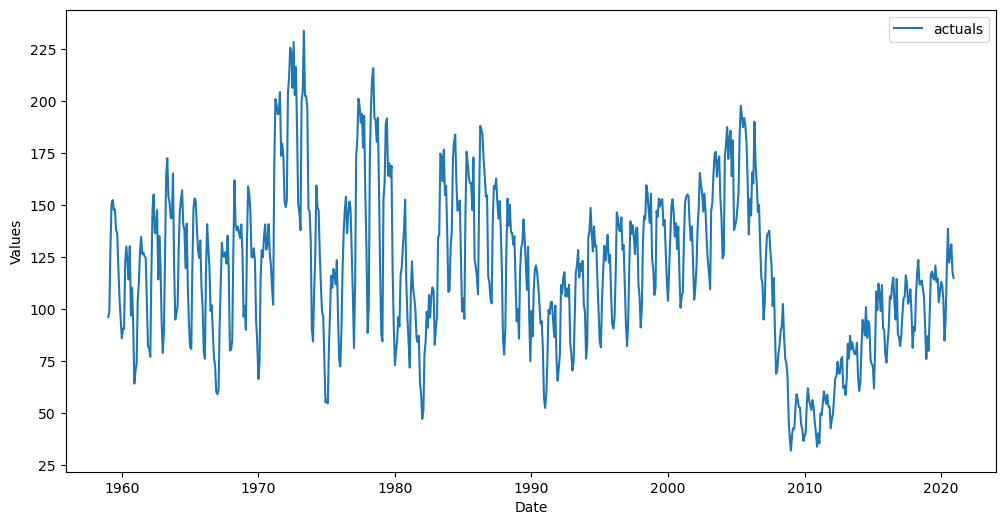

In [17]:
f = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24,
)

f.plot()
plt.show()

In [18]:
f.auto_Xvar_select()
f.set_estimator('xgboost')
f.ingest_grid('xgboost')
f.limit_grid_size(1)
f.cross_validate(k=3,test_length=48)
f.auto_forecast()

<AxesSubplot: xlabel='Date', ylabel='Values'>

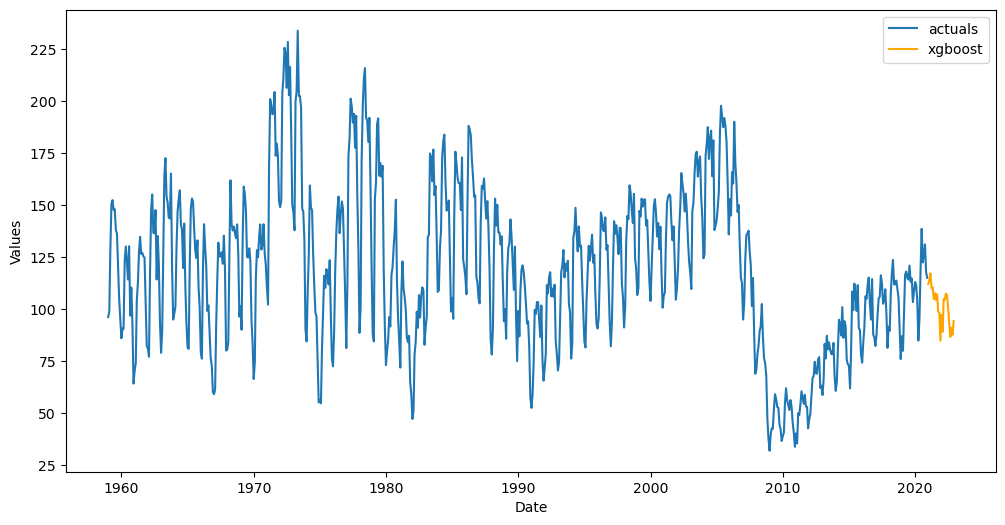

In [19]:
f.plot()

<AxesSubplot: xlabel='Date', ylabel='Values'>

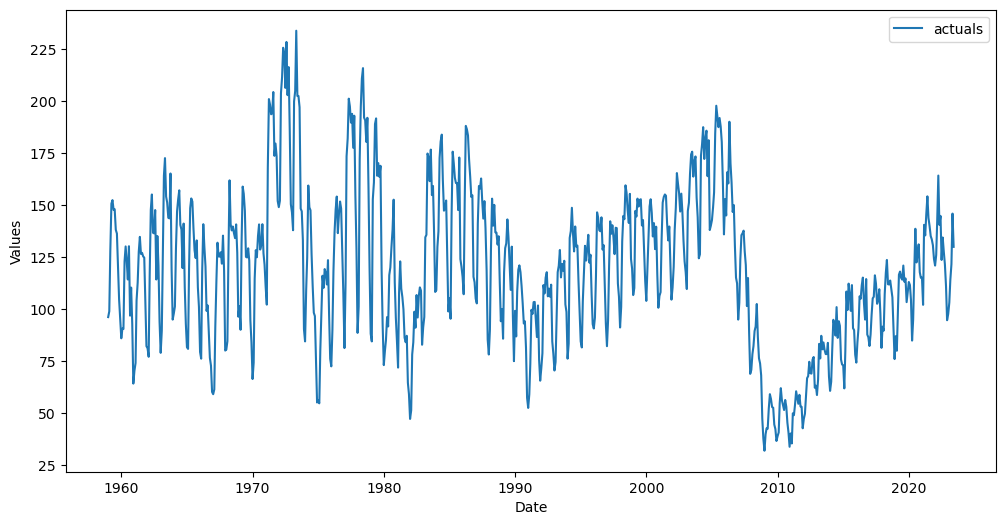

In [20]:
f_new = Forecaster(
    y = df_new.iloc[:,0],
    current_dates = df_new.index,
    #future_dates = 24,
)

f_new.plot()

In [21]:
f_new = infer_apply_Xvar_selection(infer_from=f,apply_to=f_new)

In [22]:
f_new

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2023-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=774
    ForecastLength=0
    Xvars=['AR1', 'AR2', 'AR3', 'AR4']
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [24]:
f_new.transfer_predict(transfer_from=f,model='xgboost')

<AxesSubplot: xlabel='Date', ylabel='Values'>

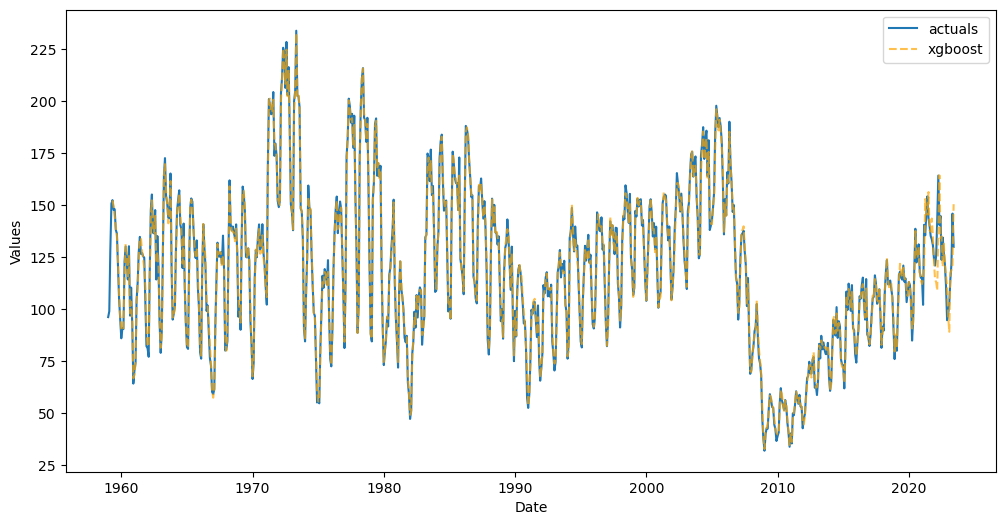

In [25]:
f_new.plot_fitted()